<a href="https://colab.research.google.com/github/xuexi21/RL_CO_training/blob/main/MOON_A2C_TEST4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- ## prepare the data -->

# use the old env setting, see above links, but new RL algrithem (actor-critic)

In [ ]:
# Dataset

import numpy as np
import matplotlib.pyplot as plt

#
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import make_moons as moon
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# define the classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_recall_fscore_support


from tqdm.notebook import tqdm


In [ ]:
# set the dataset.
dataset = moon(5000, noise=0.3, random_state=42)
X,y = dataset

# split the training(labeled) as 10% of dataset
X_l, X_ul, y_l, y_ul = train_test_split(X, y, test_size=0.8, random_state=0)


# split the training(labeled) as 50% of  labeled dataset
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y_l, test_size=0.5, random_state=0)

# 2-classifier
clf_1 = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=11))
        ]
)

# clf 1
clf_2 = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("RF", RandomForestClassifier())
        ]
)

clfs = [clf_1,clf_2]


In [ ]:
# define ENV

# for clustering the unlabeld data



class Env():
    def __init__(self, classifiers, input_ul_data, k, X_test, y_test, X_reset, y_reset):
        # super().__init__
        self.models = classifiers

        # UN LABEL DATA
        self.X_ul = input_ul_data
        # define the evaluate data, later use for the reward
        self.X_eval = X_test
        self.y_eval = y_test
        self.X_reset = X_reset
        self.y_reset = y_reset
        # cluster the data
        self.action_size = k
        self.kmeans = KMeans(n_clusters=k,  n_init=10)
        self.cluster_label = self.kmeans.fit_predict(self.X_ul)
        self.u_cluster_label = np.unique(self.cluster_label)
        self.centroids = self.kmeans.cluster_centers_
        self.observation_size = self.get_state(reset=True).shape[1]
        self.prev_macro_f1 = 0.0

    # def cluster_plot(self):
    #     for i in self.u_cluster_label:
    #         plt.scatter(self.X_ul[self.cluster_label == i , 0] ,
    #                     self.X_ul[self.cluster_label == i , 1] ,
    #                     label = i)
    #     plt.scatter(self.centroids[:,0],
    #                 self.centroids[:,1],
    #                 s=80,
    #                 color='k')
    #     # plt.legend()
    #     plt.title(f'{self.k} cluster (centroids) of unlabeled data')
    #     plt.show()

    # update 2 clf
    def train_2_clf(self, X, y):
        self.models[0].fit(X, y)
        self.models[1].fit(X, y)

    def get_state(self,reset=False):
        np.random.seed(123)
        if reset:
            self.train_2_clf(self.X_reset, self.y_reset)
            # print("reset")
        out_1 = self.models[0].predict_proba(self.centroids)
        out_2 = self.models[1].predict_proba(self.centroids)
        state_proba = np.concatenate((out_1, out_2), axis=1)
        return  torch.from_numpy(state_proba).to(torch.float32).reshape(1, -1)


    # def get_acc(self):
    #     pred_1 = self.model_1.predict(self.X_eval)
    #     pred_2 = self.model_1.predict(self.X_eval)
    #     acc_1 = accuracy_score(pred_1, self.y_eval)
    #     acc_2 = accuracy_score(pred_2, self.y_eval)
    #     return acc_1, acc_2
    def get_f1(self):
        classifier_weights = [clf.score(self.X_eval, self.y_eval) for clf in [self.models[0], self.models[1]]]  # Weights based on validation accuracy
        combined_probabilities = np.average(
            [clf.predict_proba(self.X_eval) for clf in [self.models[0], self.models[1]]],
            axis=0,
            weights=classifier_weights
        )

        # Get final predictions from combined probabilities
        combined_predictions = np.argmax(combined_probabilities, axis=1)


        # Calculate F1 scores per class (harmonic means)
        precision, recall, f1_per_class, _ = precision_recall_fscore_support(self.y_eval, combined_predictions, average=None)

        # Compute Macro-F1 as arithmetic mean of F1 scores
        macro_f1 = np.mean(f1_per_class)

        return macro_f1

    # def get_acc(self):
    #     pred_1 = self.model_1.predict(self.X_eval)
    #     pred_2 = self.model_1.predict(self.X_eval)
    #     acc_1 = accuracy_score(pred_1, self.y_eval)
    #     acc_2 = accuracy_score(pred_2, self.y_eval)
    #     return acc_1, acc_2

    ######
    ######
    def get_subset(self, action):
        # choose subset
        subset = self.X_ul[self.cluster_label == action]
        return subset

    def co_training(self, subset):

        # Average class probabilities across classifiers
        avg_probabilities = np.mean([clf.predict_proba(subset) for clf in self.models], axis=0)

        # Assign the label with the highest average probability
        y_ul_action = np.argmax(avg_probabilities, axis=1)

        ########### update the label_set for traning
        X_updated = np.concatenate((X_l_train, subset), axis=0)
        y_updated = np.concatenate((y_l_train, y_ul_action), axis=0)

        # print(f'X shape is {X_updated.shape} \ny shape is {y_updated.shape}')

        ############# use the updated labeld dateset retrain those 2 classifier
        self.train_2_clf(X_updated, y_updated)

        # RETURN THE co-trained CLASSIFIER'S mean marcof1.
        marco_f1 = self.get_f1()
        return marco_f1

    def step(self, action):
        # GET THE bigining state accuracy, later use to calculate the reward
        self.prev_macro_f1 = self.get_f1()

        # choose subset
        choosen_subset =  self.get_subset(action)

        # cotraining the 2 classifier
        new_marco_f1 = self.co_training(choosen_subset)

        # get the next state_
        n_state = self.get_state()

        ##############
        # calculate the reward
        ##############
        if new_marco_f1 > self.prev_macro_f1:
            reward_0 = new_marco_f1 - self.prev_macro_f1
        else:
            reward_0 = 0

        return n_state, reward_0, new_marco_f1


In [ ]:
k = 20
env = Env(clfs, input_ul_data=X_ul, k=k, X_test=X_l_test, y_test=y_l_test, X_reset=X_l_train, y_reset=y_l_train)
# state_0 = env.get_state(reset=True)
# # env.cluster_plot()
# # env.get_acc()
# # env.get_subset(2)
# state, reward, marco_f1 = env.step(19)
# state.shape
# reward

# print(state_0)
# print(state)


<!-- #### DQN

<img src="https://yinyoupoet.github.io/images/%E6%B7%B1%E5%BA%A6%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A0%E4%B9%8B%E6%B7%B1%E5%BA%A6Q%E7%BD%91%E7%BB%9CDQN%E8%AF%A6%E8%A7%A3/1_8coZ4g_pRtfyoHmsuzMH6g.png" alt="Description of the image" width="400" height="300">

##### loss


<img src="https://yinyoupoet.github.io/images/%E6%B7%B1%E5%BA%A6%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A0%E4%B9%8B%E6%B7%B1%E5%BA%A6Q%E7%BD%91%E7%BB%9CDQN%E8%AF%A6%E8%A7%A3/1_YCgMUijhU4p_y3sctvu-kQ.png" alt="Description of the image" width="300" height="50">




 -->


In [ ]:
# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        # Shared layers
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)

        # Actor: outputs action probabilities (softmax)
        self.actor = nn.Linear(128, action_size)


        # Critic: outputs state value (for advantage calculation)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Policy (actor): softmax over actions
        action_probs = torch.softmax(self.actor(x), dim=-1)

        # Value (critic): state value estimation
        state_value = self.critic(x)

        return action_probs, state_value

In [ ]:
# Assuming the ActorCritic class and environment 'env' are properly defined
# Create an instance of the ActorCritic network

actor_critic = ActorCritic(env.observation_size, env.action_size)
optimizer = optim.Adam(actor_critic.parameters(), lr=0.001)

# Training parameters
num_episodes = 300
gamma = 0.99

#track scores
episode_rewards = []

In [ ]:
# Main training loop
for episode in tqdm(range(num_episodes)):
    state = env.get_state(reset=True)
    # state = torch.FloatTensor(state).unsqueeze(0)  # Shape adjustment for single sample
    episode_reward = 0

    for t in range(1, 200):  # Limit the number of time steps
        # No need to use GradientTape; PyTorch handles gradients automatically
        # Choose an action using the actor
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()


        # Take the chosen action and observe the next state and reward
        next_state, reward, f1 = env.step(action.item())
        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # Compute the advantage
        # _, state_value = actor_critic(state)
        _, next_state_value = actor_critic(next_state)
        advantage = reward + gamma * next_state_value - state_value

        # Compute actor and critic losses
        actor_loss = -dist.log_prob(action) * advantage.detach()
        critic_loss = advantage.pow(2)

        # Combine losses for joint update
        total_loss = actor_loss + critic_loss

        # Update actor and critic
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        state = next_state
        episode_reward += reward
        # print(t)


        # if done or truncated:
        #     break
    episode_rewards.append(episode_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}")

  0%|          | 0/300 [00:00<?, ?it/s]

Episode 0, Reward: 0.5461528015920408
Episode 10, Reward: 0.6727182139378032
Episode 20, Reward: 0.615073757528186
Episode 30, Reward: 0.026562759301433814
Episode 40, Reward: 0.44667759992576206
Episode 50, Reward: 1.2552316857869923
Episode 60, Reward: 1.388327384120899
Episode 70, Reward: 1.3701942303524546
Episode 80, Reward: 1.4024534694205641
Episode 90, Reward: 1.4024534694205641
Episode 100, Reward: 1.4024534694205641
Episode 110, Reward: 1.3904812774522068
Episode 120, Reward: 1.4024534694205641
Episode 130, Reward: 1.4024534694205641
Episode 140, Reward: 1.4024534694205641
Episode 150, Reward: 1.4024534694205641
Episode 160, Reward: 1.4024534694205641
Episode 170, Reward: 1.4024534694205641
Episode 180, Reward: 1.4024534694205641
Episode 190, Reward: 1.4024534694205641
Episode 200, Reward: 1.4024534694205641
Episode 210, Reward: 1.4024534694205641
Episode 220, Reward: 1.4024534694205641
Episode 230, Reward: 0.003971024753702035
Episode 240, Reward: 0.003971024753702035
Episod

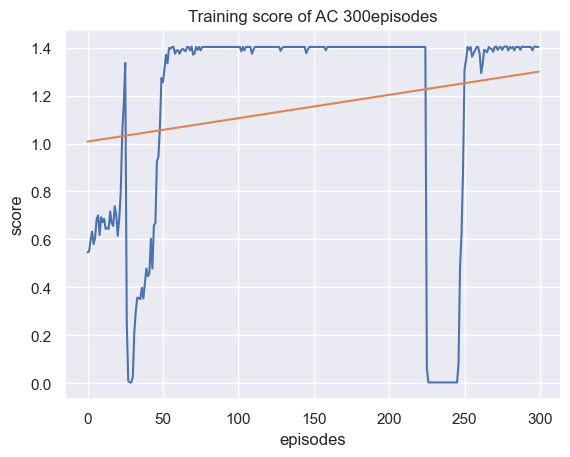

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(episode_rewards)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title(f'Training score of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(episode_rewards)).reshape(-1, 1), np.array(episode_rewards).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(episode_rewards)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [ ]:
# done = False
# state = env.reset()[0]
scores = []

for test in tqdm(range(20)):
    state = env.get_state(reset=True)
    # state = torch.FloatTensor(state).unsqueeze(0)  # Shape adjustment for single sample
    done = False
    score = 0
    for step in range(60):
        #env.render()
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        # Take the chosen action and observe the next state and reward
        next_state, reward, f1 = env.step(action.item())
        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # next_state = torch.FloatTensor(next_state).unsqueeze(0)
        score += reward
        state = next_state
    scores.append(score)

  0%|          | 0/20 [00:00<?, ?it/s]

0.4263409752136946
20


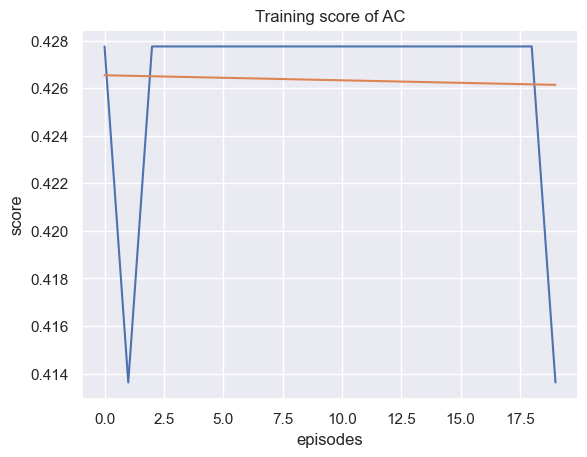

In [ ]:
print(np.array(scores).mean())
print(len(scores))


sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of AC')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [ ]:

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in actor_critic.state_dict():
    print(param_tensor, "\t", actor_critic.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
fc1.weight 	 torch.Size([128, 80])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([128, 128])
fc2.bias 	 torch.Size([128])
actor.weight 	 torch.Size([20, 128])
actor.bias 	 torch.Size([20])
critic.weight 	 torch.Size([1, 128])
critic.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {0: {'step': tensor(59700.), 'exp_avg': tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.6052e-45, 5.6052e-45, 5.6052e-45,  ..., 5.6052e-45, 5.6052e-45,
         5.6052e-45],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [5.6052e-45, 5.6052e-45, 5.6052e-45,  ..., 5.6052e-45, 5.6052e-45,
         5.6052e-45],
        [5.6052e-45, 5.6052e-45, 5.6052e-45,  ..., 5.6052e-45, 5.6052e-45,
         5.6052e-45],
        [5.6052e-45, 5.6052e-45, 5.6052e-45,  ..., 5.6052e-45, 5.6052e-45,
         5.6052e-45]]), 'exp_avg_sq': tensor([[0.0000e+00, 0.0000e+00, 0

In [ ]:
#SAVING THE NETWORK.
import os

cwd = os.getcwd()

# Assume `model` is your neural network
torch.save(actor_critic.state_dict(), cwd+'/AC.pth')


In [ ]:
# LOADING THE NETWARK
# model = QNetwork(*args, **kwargs)
# model.load_state_dict(torch.load(PATH, weights_only=True))
# model.eval()